# Fundamentals

1. (2pt) We want to automate the task of determining whether a patient has some diseases based on their symptoms. We decided to use a neural network to solve the problem with the following choices: Either to train a separate neural network for each disease, or to train a single neural network with an output neuron for each disease, but with a shared hidden shared hidden layer. Which method do you prefer? Justify your answer.

I prefer only one NN for all class.
- Training a single network for each disease won't allow the network to learn the true underlying distribution of the disease. In the case of a CNN reading images of disease, the CNN won't be able to capture the slight variation between two picture of disease because he wouldn't have ever seen the other disease. Thus, an CNN trained to predict one class won't be able to succesfully distinguish two disease.
- In practice, having ten different NN is tedious to implement and not efficient. You would have have to do X forward pass instead of only one with an NN trained on all class.

2. You want to create a model that takes as input an image and out- puts a caption. Propose an adequate model architecture and justify your answer.


A convolution neural network is an adequate architecture for this task. An MLP architecture can't be used because an image contains an enormous amount of pixel which all requires parameters connected to them. We would have to represent the image as a very long columns with 100X100 rows for a 100 by 100 pixels image. 
Another reason is that we want to capture the correlation between a set of pixels, this allow the model to detect interesting features and edges in the image.  

3. (2pt) What are the advantages and disadvantages of both GMMs and K-means? How do they compare to each other?

GMMs
The advantages of GMMs is that it can model cluster which shape are not circular and can be of different size. 
Disadvantages is that the number of parameters is very large for GMMs, because it has to estimate all the covariance matrix. The cov matrix represent the shape of the cluster. Another disadgvantage is that GMMs can only model clutser with normal distribution, 

KNN
Advantage: Knn is not computationaly expensive due to his iterative nature. 
Disadvantage: Knn is very sensitive to outliers and need cluster that are circular and of same size. 

4. (2pt) Both RNNs and Autoencoders can be used to produce outputs of the same size as the input. Their power can be combined through architectures such as LSTM Autoencoder. Explain the advantage of such architecture, some of its potential applications and its limitations.

Autoencoder are within the family of generative model, they are use to represent the input data in smaller dimension. The goal is to capture the true explanatory variable that form the input dataset. With the encoder, having well represented in a smaller dimension the dataset (this is capture in a latent variable), the decoder can reproduce the inputs from the latent variable. 

LSTM is a variant of RNN that help to get around the problem of vanishing gradient and exploding gradient of RNN. LSTM uses gates, the first gate (forget gate) tells what percentage of Long-term Memory is remembered. At each iteration we are updating the long-term and short-term memory. The fact that we are seperating those two memory, is what makes the gradient not vanishing or exploding.

LSTM Autoencoder have an encoder and a decoder architecture, the lstm allows for reading the input sequence sequentially and learn a representation of that input sequence. From the representation contain in a fixed lenght-vector use as input by the decoder, this latter can use that output of the encoder to recreate the input sequence.  Thus, an LSTM Autoencoder is concerns with reconstructing the input sequence. 

Applications: Reconstruct Speech, video, text and time series sequence. 

Limitations: Computationaly expensive

5. (2pt) For each layer, calculate the number of weights, number of biases and the size of the associated feature maps of the convolutional neural network in the table. The notation follows the convention:
- CONV-K-N denotes a convolutional layer with N filters, each them of size K ×K, Padding and stride parameters are always 0 and 1 respectively.
- POOL-K indicates a K × K pooling layer with stride K and padding 0.
- FC-N stands for a fully-connected layer with N neurons.

            Activation     | # of Weights   | # of Bias
            
CONV-9-32 | 120 X 120 X 32 | 9X9X32 = 2592  | 32

POOL-2    | 60 X 60 X 32   | 0              | 0 

CONV-5-64 | 56 X 56 X 64   | 1600           | 64

POOL-2    | 28 X 28 X 64   | 0              | 0

FC-3      | 50 176 X 3     | 150 528        | 3

# Convolutional neural networks

**Task:** train a Convolutional Neural Network to predict different weather conditions from an image.

**Classes**: Snow, Rain, Rainbow, Fogsmog, Dew, Frost, Lightning, Sandstorm

## Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib

import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F

import time # to see how long the code needs to run 
import os # to read files
import copy
from torchvision.datasets import ImageFolder

/opt/anaconda3/envs/Flower/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Random seeds for reproducibility
#DO NOT CHANGE
torch.manual_seed(0)
np.random.seed(0)

In [3]:
data_dir = 'weather_dataset/'

In [21]:
####if you are using colab, create a directory using this command, else: unzip the folder in the same directory as this notebook
#!mkdir weather_dataset

In [22]:
## ... and unzip the file using 
# !unzip 'weather_dataset.zip' -d weather_dataset

1. (2pt) Using matplotlib, create a function that visualizes an image from the training set of each class.

In [59]:
#helper code that reads images from each class
images = list()
labels = list()
path = 'weather_dataset/train/'
for dirname in os.listdir(path):
    path1 = path + dirname
    images.append(os.path.join(path1,os.listdir(path1)[-1]))
    labels.append(dirname)

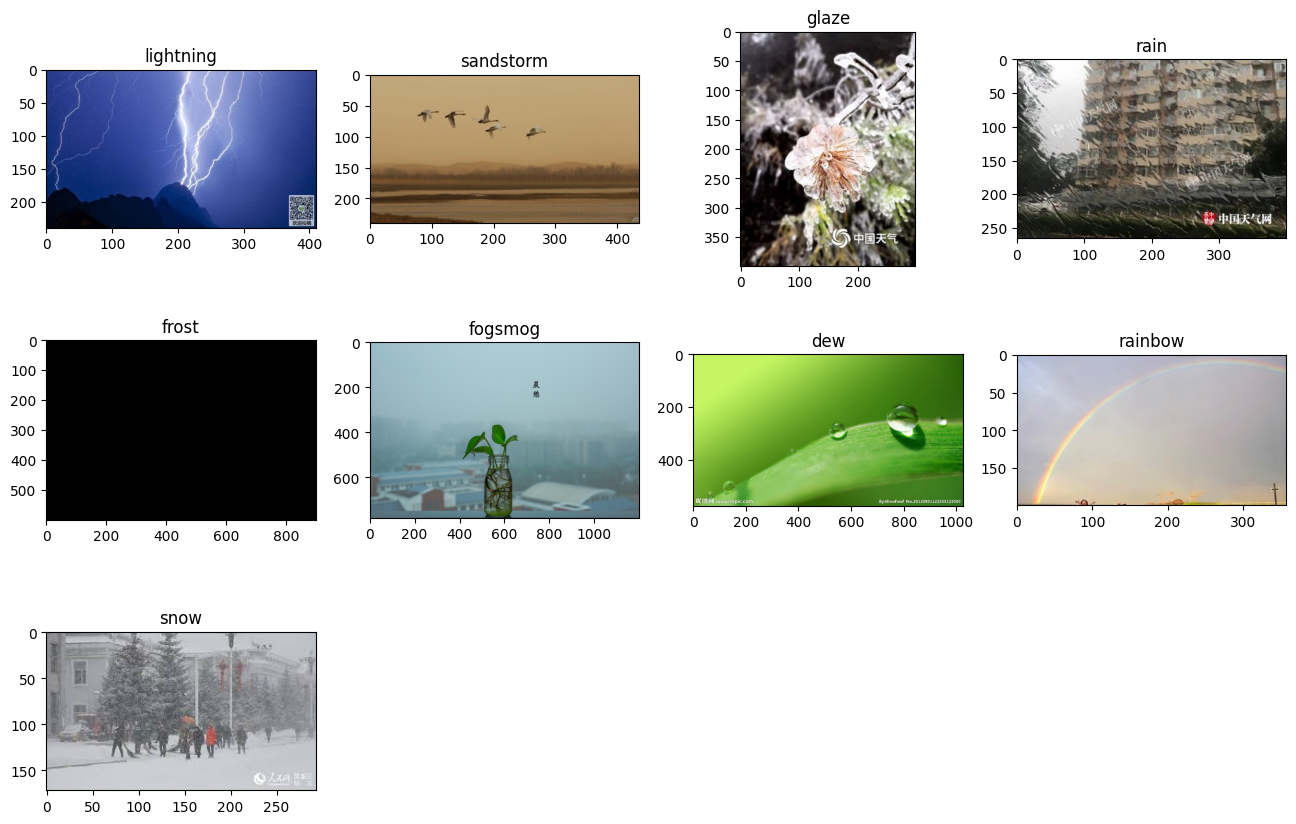

In [35]:
def visualizer(images,labels):
  plt.figure(figsize=(16, 14))
  n = 0
  for image, label in zip(images, labels):
    n+=1
    ax = plt.subplot(4, 4, n)
    img = plt.imread(image).astype('int')
    plt.imshow(img)
    # chart formatting
    ax.set_title(label)
    ax.set_ylabel("")
visualizer(images,labels)

In [5]:
batch_size = 16
input_size = 32
num_classes = 9

2. (2pt) Implement data transformations to apply to the training and validation sets. 
The transformations for training set should be a composition of:
- resizing using Resize() with input_size
- adding a CenterCrop() with input_size
- adjusting the sharpness using RandomAdjustSharpness(sharpness_factor=2)
- Adding a RandomHorizontalFlip()
- transforming the images to tensors
- Normalizing([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

The transformations for the validation set should be a composition of:
- resizing using Resize()
- transforming the images to tensors
- Normalizing([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

You can read about other possible transformations to augment data [here](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#randomrotation).

In [6]:
data_transforms={}
data_transforms['train'] = transforms.Compose(
    [transforms.Resize(size=(input_size, input_size)),
     transforms.CenterCrop(size=input_size),
     transforms.RandomAdjustSharpness(sharpness_factor=2),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
     ]
)

data_transforms['val'] = transforms.Compose(
    [transforms.Resize(size=(input_size, input_size)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
     ]
)

print("Initializing Datasets and Dataloaders...")
data_dir = os.getcwd()+'/weather_dataset'
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

Initializing Datasets and Dataloaders...


3. Implement a CNN with the following architecture:
*  It has 3 convolutional layers, followed by a linear layer.
*  Each convolutional layer has a kernel size of 3, a padding of 1.
*  ReLU activation is applied on every hidden layer.
*  Max pooling layer with kernel size of 2 and stride of 2.
*  The last layer should be a linear layer.
*  The number of input and output channels is (3,5), (5,5), (5,5)

(6pt) Complete both the init and forward functions in the code below.

In [17]:
class CNN_homework2(nn.Module):
    def __init__(self):
        super(CNN_homework2, self).__init__()
            ##insert the components here (3pt)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3, stride=1, padding=1)
        self.max_pooling = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = nn.Linear(5 * 4 * 4, num_classes)

    def forward(self, x):
        # implement the forward function here (3pt)
        x = self.max_pooling(torch.nn.functional.relu(self.conv1(x)))
        x = self.max_pooling(torch.nn.functional.relu(self.conv2(x)))
        x = self.max_pooling(torch.nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 5 * 4 * 4)
        x = self.linear(x)
        return x

4. (2pt) Define the optimizer and the loss function.
You will use Adam optimizer and cross entropy loss.

In [18]:
import torch.optim as optim
lr = 1e-3
num_epochs = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_homework2()
model.to(device)
##########ADD YOUR ANSWER HERE#############
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

5. a) (2pt) Modify the training function so that it also returns the history of training and validation loss

In [19]:
#We use the same training function that you used in class
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()

    val_acc_history = []
    ######### Store the loss values here##############
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_loss_history, val_loss_history

In [20]:
# Train and evaluate
#Uncomment to run
model, hist, train_loss_history, val_loss_history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 1.8005 Acc: 0.3531
val Loss: 1.5500 Acc: 0.4834

Epoch 1/49
----------
train Loss: 1.3161 Acc: 0.5651
val Loss: 1.3377 Acc: 0.5734

Epoch 2/49
----------
train Loss: 1.1405 Acc: 0.6241
val Loss: 1.2116 Acc: 0.5890

Epoch 3/49
----------
train Loss: 1.0771 Acc: 0.6464
val Loss: 1.1959 Acc: 0.6008

Epoch 4/49
----------
train Loss: 1.0335 Acc: 0.6540
val Loss: 1.1861 Acc: 0.6184

Epoch 5/49
----------
train Loss: 1.0241 Acc: 0.6557
val Loss: 1.1896 Acc: 0.6086

Epoch 6/49
----------
train Loss: 0.9983 Acc: 0.6619
val Loss: 1.1321 Acc: 0.6184

Epoch 7/49
----------
train Loss: 0.9710 Acc: 0.6712
val Loss: 1.0790 Acc: 0.6282

Epoch 8/49
----------
train Loss: 0.9498 Acc: 0.6802
val Loss: 1.0511 Acc: 0.6341

Epoch 9/49
----------
train Loss: 0.9272 Acc: 0.6734
val Loss: 1.1393 Acc: 0.6204

Epoch 10/49
----------
train Loss: 0.9303 Acc: 0.6741
val Loss: 1.0756 Acc: 0.6360

Epoch 11/49
----------
train Loss: 0.9119 Acc: 0.6854
val Loss: 1.0841 Acc: 0.6341

Ep

5. b) (2pt) Plot the validation and training loss.

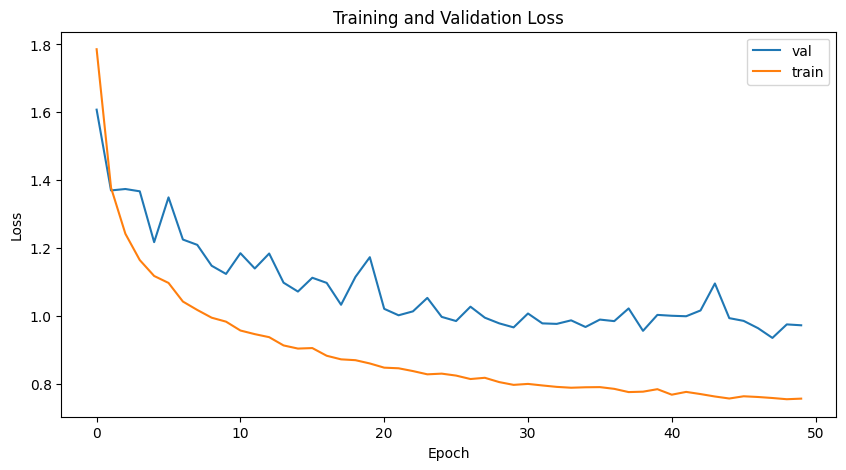

In [22]:

def plot(train_loss_history,val_loss_history):  
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(val_loss_history,label="val")
    plt.plot(train_loss_history,label="train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    pass

plot(train_loss_history,val_loss_history)

c) (4pt) Improving the model:
Suggest possible techniques that can help improve the model and implement the one of your choice. For the sake of clarity, if you are reusing a part from the code above, copy the same block below and provide explanations in the form of comments.

Your answer goes here: 

In order to increase the performance of the CNN, we can try different value for the learning rate, which would help the model in finding the global minima by taking step of different size when doing gradient descent. Another technique would be to play with the number of convolution layer, by increasing the number of layer, we let the model learn more feature as each layer catches different hierarchical representation of the image. 

In our case, having already done data augmentation, we might add different augmentation technique to the data_transform function, but I doubt that this would have a profound effect on the performance of the model. Data augmentation is very useful techniques to increase the number of label image in your dataset, this is done by blurring, flipping, orienting the object in the image in a different way. 

In terms of the architecture of the CNN, we can deepen the network in order to capture hierachical aspect of the images, we can widen the network by adding hidden units, but this could lead the model to memorize and not generalize well. We could also create residual connection, this will help the network train, by allowing gradients to flow through the networks directly. The idea of a residual layer is to connect the output from an earlier layer to the input of another convolution layer several layers after. 

Futhermore in terms of architecture, we can use pre-trained CNN model like alexnet and resnet. Those model have already been trained on huge image dataset. In order to use these model, we want to at least trained their last layer of their network on our dataset, this is done by freezing the previous layer and this process is called fine-tuning. 

When our model is overfitting, we can use a technique called dropout where when going throught the network, at each node we set a probability of eliminating that node. This help the model generalize better as we are forcing the network to not memorize the data, because he now can't rely on any features (at any time they can go away). This forces the network to spread its weight across the network.  

We could also use mini-batch gradient descent, instead of going through the entire training set before you take one step of gradient descent, you can shuffle your data in different size batch and takes a step after going through a batch of the data.

In terms of our problem, we see that some class are having very bad results. From the graph, the model seems to slightly overfit, so it could be useful to try dropout. I will also try a different value of learning rate.
I believe that it would be useful to increase the depth of the network, by adding convolution and linear layer. Maybe the model architecture is not able to well capture the representation of the specific class that doesn't perform well, or to distinguish between the class.  

In [31]:
class CNN_variant(nn.Module):
    def __init__(self):
        super(CNN_variant, self).__init__()
            ##insert the components here (3pt)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(6 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, num_classes)
        # Dropout
        self.drop1 = nn.Dropout(0.30)
        self.drop2 = nn.Dropout(0.20)
        self.drop3 = nn.Dropout(0.1)

    def forward(self, x):
        # implement the forward function here (3pt)
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = self.drop1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = self.drop3(x)
        x = self.fc3(x)

        return x

In [32]:
import torch.optim as optim
import wandb
lr = 0.005
num_epochs = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1 = CNN_variant()
model1.to(device)
##########ADD YOUR ANSWER HERE#############
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr = lr)

In [33]:
#We use the same training function that you used in class
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    # Log gradients and model parameters
    since = time.time()

    val_acc_history = []
    ######### Store the loss values here##############
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_loss_history, val_loss_history

In [16]:
# Train and evaluate
#Uncomment to run
model, hist, train_loss_history, val_loss_history = train_model(model1, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 1.6868 Acc: 0.3506
val Loss: 1.3786 Acc: 0.4658

Epoch 1/49
----------
train Loss: 1.3945 Acc: 0.4657
val Loss: 1.3317 Acc: 0.5049

Epoch 2/49
----------
train Loss: 1.2974 Acc: 0.5313
val Loss: 1.2421 Acc: 0.5558

Epoch 3/49
----------
train Loss: 1.2440 Acc: 0.5646
val Loss: 1.3015 Acc: 0.5969

Epoch 4/49
----------
train Loss: 1.2147 Acc: 0.5747
val Loss: 1.1459 Acc: 0.6086

Epoch 5/49
----------
train Loss: 1.1630 Acc: 0.5928
val Loss: 1.0764 Acc: 0.6204

Epoch 6/49
----------
train Loss: 1.1490 Acc: 0.5935
val Loss: 1.1306 Acc: 0.5988

Epoch 7/49
----------
train Loss: 1.1596 Acc: 0.6009
val Loss: 1.1027 Acc: 0.6204

Epoch 8/49
----------
train Loss: 1.1305 Acc: 0.6131
val Loss: 1.2152 Acc: 0.6027

Epoch 9/49
----------
train Loss: 1.1221 Acc: 0.6107
val Loss: 1.1162 Acc: 0.6301

Epoch 10/49
----------
train Loss: 1.1170 Acc: 0.6143
val Loss: 1.2270 Acc: 0.5616

Epoch 11/49
----------
train Loss: 1.1141 Acc: 0.6143
val Loss: 1.0849 Acc: 0.6223

Ep

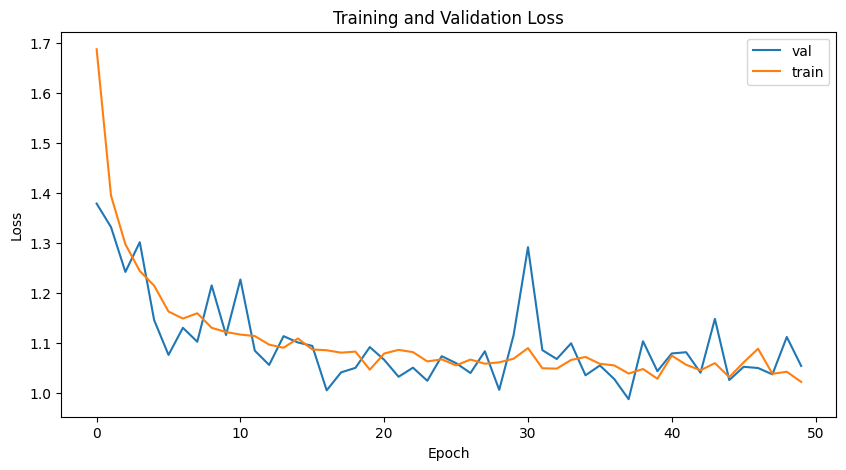

In [17]:
def plot(train_loss_history,val_loss_history):  
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(val_loss_history,label="val")
    plt.plot(train_loss_history,label="train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    pass

plot(train_loss_history,val_loss_history)

We see that our new CNN validation error is closer to our training error, thus we can say that our model seems to overfit less. This could be due to the dropout layer that we add. 

Although, the validation error is now higher than the previous model, even though we added linear layer.  

Another option would be to set up a random grid search for hyperparameter tuning, the most important hyperparameter to tune is the learning rate. In this case, I only tried (manually) 0.0001, 0.001, 0.005 and 0.01. I observed that higher lr are performing worse than smaller lr, but smaller then .001 haven't give significantly better results.   

The effect of increasing the number of epochs hasn't been significant on the performance of the model, I went until 125 epochs without gaining more than 1% in precision. 

In conclusion, our first model seems to have a better validation performance than our second model, even though it overfits. Given what I tried, I would propose too use a pretrained model like Alexnet and resnet, freeze the previous layer and keep the last layer unfreeze and train it on our dataset. If again the performance doesn't improve, the data could be taken responsible for the poor performance of the model. 

6. a) (4pt) Predict the test set and report the accuracy. 

In [55]:
#loading and transforming the test data
#the transformations should be the same as the ones used for validation data
image_dataset_test = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])
dataloader_test = torch.utils.data.DataLoader(image_dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [56]:
def evaluation(dataloader, model):
    correct = 0
    total = 0 
    target = []
    prediction = []
    with torch.no_grad():
        model.eval()
    # Iterate over data.
    for inputs, labels in dataloader_test:
        inputs_test = inputs.to(device)
        labels_test = labels.to(device)
      # forward
        y_hat = model(inputs_test)

      # calculations for accuracy
        _, predictions = y_hat.max(1)
        correct += (predictions == labels).sum()
        total += predictions.size(0)

    target.append(labels.item())
    prediction.append(predictions.item())

    print(f"Accuracy = {correct/total*100:.2f}; Received {correct}/{total}")

In [23]:
evaluation(dataloader_test, model)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Accuracy = 66.86; Received 345/516


The reported accuracy is 67.25% for the whole dataset for the CNN of question 3.

6.b) (3pt) Report the accuracy for each class. You can use a code similar to the previous question.

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np

target = []
prediction = []
with torch.no_grad():
    model.eval()
# Iterate over data.
for inputs, labels_c in dataloader_test:
    inputs_test = inputs.to(device)
    labels_test = labels_c.to(device)
    # forward
    y_hat = model(inputs_test)

    # calculations for accuracy
    _, predictions = y_hat.max(1)

    target.append(labels_c.item())
    prediction.append(predictions.item())

In [62]:
print(classification_report(target, prediction, target_names=labels))

              precision    recall  f1-score   support

   lightning       0.82      0.76      0.79        70
   sandstorm       0.73      0.85      0.78        86
       glaze       0.46      0.27      0.34        48
        rain       0.50      0.30      0.37        64
       frost       0.80      0.92      0.85        38
     fogsmog       0.58      0.66      0.62        53
         dew       0.73      0.46      0.56        24
     rainbow       0.72      0.83      0.77        70
        snow       0.56      0.76      0.65        63

    accuracy                           0.67       516
   macro avg       0.66      0.64      0.64       516
weighted avg       0.66      0.67      0.65       516



6. c) (3pt) Which classes have lowest accuracy? Which one has the best accuracy? 
What might be the reason behind this? Justify your answer.
For this question, you can use code or text or both. 

The class with the highest accuracy is frost. 
Here, we find that the frost, rain, fog, and snow classes perform the worst. 

 This may be due to the fact that the model architecture is not able to properly capture the representation of the worst performing class, or to distinguish between the different classes.  

 Furthermore, in a multi-class problem, some classes may not be represented as well as others. First, we may end up with classes that have very few images compared to others, and these underrepresented classes may suffer from a lower quality image. In our case, we find that the classes glaze, rain, fogsmog, and snow perform the worst. Images such as rain, fogsmog and snow seem more difficult to classify because the images are blurred due to the nature of the picture (i.e snow). Thus, the distinguishing features are difficult to detect.  

 We would have to create a function to tells us how many training examples per class, we could then identify if the classes that perform well or bad is due to small number of training example relative to other classes. Ç

# Training RNNs
In this section, we will train RNNs to perform a text classification task.

## Install torchtext (optional)
Uncomment and run this command if you have not already installed torchtext and torchdata. You can also run this command from the terminal if running your code outside of a notebook environment.

## Chunking text
We will be using the dataset CoNLL2000Chunking to perform chunking over text. You can find more information about the dataset and chunking text by clicking the following [link](https://www.clips.uantwerpen.be/conll2000/chunking/). Each sequence of words is given a tag describing its part-of-speech, as well as a chunk type. The goal is to correctly classify the chunk class given the sequence of words as input. We will use RNNs to do so. In order to determine the efficiency of our model, we will report the F-score for each chunk class (definition given later).

Each word is assigned to a chunk type which describes its role in a sentce. They can belong to a noun phrase, verb phase, prepositional phrase, etc. The complete list of basic chunk types can be found in this [article](https://www.clips.uantwerpen.be/conll2000/pdf/12732tjo.pdf). The basic chunk types all come in two flavours denoted with a prepended "B-" or "I-". For example, "B-NP" implies that a word begins a noun phrase, while a a chunk type of "I-NP" implies that it belongs to some other part of a noun phrase. The only chunk type that has one unique tag is the chunk type "O", or "word outise of any chunk"

In [2]:
import torch
from torch.utils.data import DataLoader
from torchtext.datasets import CoNLL2000Chunking


# DataPipe containing the dataset
dp = CoNLL2000Chunking()

In [3]:
# Split the DataPipe into training and test sets
dp_train, dp_test = dp

In [4]:
# Attribute an index to each word in the trainig set
# You will need to have an embedding for each of them
# The embeddings are retrieved using the indices
# You need to define an embedding for tags not in this dict
# This will serve as a catch-all tag for words not in the dictionary
words = {}

# indices used for the chunks
# You will need to have an embedding for each of them
# The embeddings are retrieved using the indices
labels = {
    "B-NP": 0, "I-NP": 1,
    "B-VP": 2, "I-VP": 3,
    "B-PP": 4, "I-PP": 5,
    "B-ADVP": 6, "I-ADVP": 7,
    "B-SBAR": 8, "I-SBAR": 9,
    "B-ADJP": 10, "I-ADJP": 11,
    "B-PRT": 12, "I-PRT": 13,
    "B-CONJP": 14, "I-CONJP": 15,
    "B-INTJ": 16, "I-INTJ": 17,
    "B-LST": 18, "I-LST": 19,
    "B-UCP": 20, "I-UCP": 21
}

# indices used for the part-of-speech tags
# You will need to have an embedding for each of them
# The embeddings are retrieved using the indices
# You need to define an embedding for tags not in this dict
# This will serve as a catch-all tag for things like ',' and '.'
tags = {
    "AT":0, "HVD": 1, "IN": 2, "MD": 3,
    "NN": 4, "NP": 5, "PPS": 6, "PPO": 7,
    "TO": 8, "VB": 9, "VBN": 10, "VBD": 11
}

for batch in DataLoader(dp_train, batch_size = None):
  tokens, _, chunks = batch
  for token in tokens:
    if token not in words:
      words[token] = len(words)

## Model definition
The RNN model is defined using the equations
$$h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1} W_{hh}^T + b_{hh})$$
$$y_t = h_t W_{ho}^T$$
where $x_t$ is the input, $h_t$ is the hidden layer and $y_t$ is the output at position $t$ in the sequence. We of course start with $h_0$ to be a vector of zeros.

### Q1
In this question, you will need to do the following by filling out the skeleton of the code:

a. (5pt) Define all layers in the `__init__` of the `RNN` class. You are required to only have one hidden layer and one output layer in the RNN cell as in the previous equation. You will need to define two embedding layers, one for words and one for the part-of-speech tag. These two embedding should have `len(words) + 1` and `len(tags) + 1` input features (see remark below) and `hidden_size // 2` output features

b. (5pt) Define the `forward` method. This method should perform all the computations of the $y_t$ and the $h_t$ for each position $t$ in the training sequence.

c. (5pt) Define the methods `word_embed` and `target_embed` that compute the word embeddings and tag embeddings given a sequence of words and a sequence of tags of the same length.

Remark: Note that `new_token` and `new_tag` correspond to a catch-all value when we have a word or a tag that is not part of the dictionaries.

In [5]:
# Define the RNN model that will be used
from torch.nn import Embedding, Linear
class RNN(torch.nn.Module):
  def __init__(self, hidden_size):
    """
    Initialize the RNN module
    :param hidden_size: Number of hidden neurons for each hidden layer
    """
    super().__init__()
    # TODO: Define all the layers. You can use Linear and Embeddign objects
    self.hidden_size = hidden_size
    #embedding layers for word (len(words)+1)
    self.word_embed_layer = torch.nn.Embedding(len(words)+1, hidden_size//2)
    # embedding layers for part-of-speech (len(tags)+1)
    self.tag_embed_layer = torch.nn.Embedding(len(tags)+1, hidden_size//2)
    # Output layer 
    self.RNNCell =  nn.RNNCell(hidden_size, hidden_size)
    self.o =  nn.Linear(hidden_size, len(labels))
  
    pass

  #def _initial_state(hidden_dim):
  #  return np.zeros((1, hidden_dim))

  def forward(self, input, h_0):
    """
    Forward method of the RNN
    :param input: input of size (sequence_length, batch_size, hidden_size)
    :param h_0: initial hidden layer. Size needs to be broadcastable to (batch_size, hidden_size)
    :returns y, h_n: y is output of size (sequence_length, batch_size, len(targets)) and h_n is of size (batch_size, hidden_size)
    """
    # TODO: Loop over sequence length to compute all y_t and h_t
    # You can use torch.stack to combine the y_t into a y tensor with dimension 0 of size sequence_length
    # Initialize hidden state with zeros      
   # word_input = self.word_embed_layer(words)
    #tags_input = self.tag_embed_layer(tags)
    #input = torch.cat((word_input, tags_input)) # 10 and 64

    # Loop over all time step
    output_list = []
    self.h = h_0
    for x in input:
      self.h = self.RNNCell(x, self.h)
      output = self.o.forward(self.h[0])
      output_list.append(output)

    return torch.stack(output_list), self.h

    pass

  def word_embed(self, tokens):
    """
    Method to compute the word embedding of a token sequence
    :param tokens: single input from the DataLoader
    return embeddings: tensor of size (sequence_length, 1, hidden_size // 2)
    """
    # TODO: use an embedding layer defined in the init method
    # Retrieve the embedding of new_token whenever key is not in dictionary
    new_token = len(words)
    token_idx = torch.tensor([[words[token] if token in words else new_token for token in token_batch] for token_batch in tokens], dtype = torch.long)

    return self.word_embed_layer(token_idx)

  def tag_embed(self, poss):
    """
    Method to compute the tag embedding of a part-of-speech sequence
    :param poss: single input from the DataLoader
    return embeddings: tensor of size (sequence_length, 1, hidden_size // 2)
    """
    new_tag = len(tags) 
    # TODO: Use an emebdding layer defined in the init method
    # Retrieve the embedding of new_tag whenever key is not in dictionary
   #tag_idx = torch.tensor([[words[tags] if tags in words else new_tag for tags in poss_batch] for poss_batch in poss], dtype = torch.long)
    tag_idx = torch.tensor([[tags[tag] if tag in tags else new_tag for tag in poss_batch] for poss_batch in poss], dtype = torch.long)

    return self.tag_embed_layer(tag_idx)
    pass

  def target_label(self, chunks):
    """
    Method to compute the target embedding of a chunk sequence
    :param chunks: single input from the DataLoader
    return embeddings: tensor of size (sequence_length, 1, hidden_size)
    """
    new_chunk = len(labels) - 1 # Used for the O chunk type when key is not found in dictionary
    # TODO: Use an embedding layer defined in the init method
    # Retrieve the embedding of new_chunk whenever key is not in dictionary
    label_idx = torch.tensor([[labels[chunk] if chunk in labels else new_chunk for chunk in chunks_batch] for chunks_batch in chunks], dtype = torch.long)

    return label_idx
    pass

### Q2
In this question, you will have to do the following by filling the skeleton of the code below:

a. (5pt) Use `tokens` to pass it to the word embedding layer. Use `poss` to pass it to the tag embedding layer. Concatenate the two tensors on the feature dimension (i.e. the last dimension).

b. (5pt) Compute the loss using `loss_fn` by using the concatenated tensors as input and `chunks` as targets. You might have to cast tensors to the same type to compute it. It can also be useful to use `.view` on tensors to reshape them before passing them to `loss_fn`. Append the average loss over the sequence to `batch_loss`.

c. (5pt) Compute the predicted class over the sequence. You will have to use `.argmax` over the output dimension (i.e. the last one). Determine the precision over the sequence by finding which elements are predicted to the right class.Append the average precision over the sequence to `batch_prec`.

d. (5pt) Compute the gradients and update the parameters. Remember to be careful about gradients that were computed on the previous batch ...

In [12]:
from numpy import mean
# Define the training function
from torch.nn import CrossEntropyLoss
def train(model, optim, epochs):
  model.train()
  loss_fn = CrossEntropyLoss()
  train_loss = []
  for epoch in range(epochs):
    batch_loss = []
    batch_prec = []
    for batch in DataLoader(dp_train, shuffle = True):
      optim.zero_grad()
      tokens, poss, chunks = batch
      # TODO: Get embeddings and pass to RNN
      # input to the model should have size (sequence_length, 1, hidden_size)
      # y should have size (sequence_length, 1, hidden_size)
      # You can use y.view(-1, len(labels)) before passing to loss_fn
      # The targets should be a tensor of size (sequence_length, )
      word_input = model.word_embed(tokens)
      tags_input = model.tag_embed(poss)
      x = torch.cat((word_input, tags_input), dim =2)
    
      # TODO: compute loss
      # The loss will be a tensor of size (sequence_length, )
      # You can use .sum() to get the sum over all positions
      # You can use .item() to get the final loss value to store inside batch_loss
      output,_ = model(x, torch.zeros(1,model.hidden_size))
      
      labels_train = model.target_label(chunks)
      
      outputs = output.view(-1, len(labels))

      loss = loss_fn(outputs, labels_train.reshape(-1))

      batch_loss.append(loss.item())

      #print()
      # TODO: Compute the predicted class and the precision
      # You can use .argmax(dim = -1) to find the predicted class
      #  Make sur the output is cast to torch.long dtype

      predicted_class = outputs.argmax(dim = -1)
      predicted_class = predicted_class.long() 
      running_corrects = torch.sum(predicted_class == labels_train.squeeze())/len(labels_train)
      
      batch_prec.append(running_corrects.item())

      # Perform backward and update parameters
      loss.backward()
      optim.step()
    avg_batch_loss = mean(batch_loss)
    avg_batch_prec = mean(batch_prec)
    print(f"Loss after epoch {epoch}: ", avg_batch_loss)
    print(f"Precision after epoch {epoch}: ", avg_batch_prec, "\n")
    train_loss.append(avg_batch_loss)
  return train_loss

## Testing the model

You will need to compute the F-score over each class by evaluating it on the test set.

$$F_i = 2 \cdot \text{precision}_i \cdot \text{recall}_i / (\text{precision}_i + \text{recall}_i)$$ where $F_i$ is the F-score, $\text{precision}_i$ the precision and $\text{recall}_i$ the recall over class $i$.

The value $\text{precision}_i$ is defined as $\frac{TP_i}{TP_i + FP_i}$ where $TP$ are true positives and $FP_i$ are false positives for class $i$.

The value $\text{recall}_i$ is defined as $\frac{TP_i}{TP_i + FN_i}$, where $FN_i$ are false negatives for class $i$.

### Q3
In the following question, you will have to do the following by filling the skeleton of the code below:
a. (0pt) Use ``tokens`` to pass it to the word embedding layer. Use ``poss`` to pass it to the tag embedding layer. Concatenate the two tensors on the feature dimension (i.e. the last dimension).

b. (0pt) Compute the predicted class over the sequence. You will have to use ``.argmax`` over the output dimension (i.e. the last one). 

c. (5pt) Once you have the predicted and true classes for each element of the sequence, update the confusion matrix. Access each position $(i, j)$ and add 1, where $i$ is the predicted class and $j$ is the true class.

d. (5pt) Compute the precision and recall using the confusion matrix. Compute the mean over rows for the precision and over columns for the recall. Using the tensors corresponding to precision and recall, compute the F-score using the equation above. Return the F-score

In [7]:
# Define the testing function
def test(model):
  model.eval()
  loss_fn = CrossEntropyLoss(reduction = "none")
  test_loss = []
  # Confusion matrix as a tensor
  confusion = torch.zeros(len(labels), len(labels))
  for batch in DataLoader(dp_test):
    tokens, poss, chunks = batch
    # TODO: Get embeddings and pass tp RNN
    # input to the model should have size (sequence_length, 1, hidden_size)
    # y should have size (sequence_length, 1, hidden_size)
    # You can use y.view(-1, len(labels)) before passing to loss_fn
    # The targets should be a tensor of size (sequence_length, )
    word_input_test = model.word_embed(tokens)
    tags_input_test = model.tag_embed(poss)
    input_test = torch.cat((word_input_test, tags_input_test), dim=2)
    output_test,_ = model(input_test, torch.zeros(1,model.hidden_size))
    output_test.view(-1, len(labels))
    # TODO: Compute the predicted class
    # You can use .argmax(dim = -1) to find the predicted class
    # Make sur the output is cast to torch.long dtype
    predicted_class = torch.argmax(output_test, dim = -1).long()
    predicted_class = predicted_class.long()

    # TODO: Retrieve the target class labels using model method target_label
    # Make sure the tensor is cast to torch.long dtype
    label_test = model.target_label(chunks).reshape(-1)
    label_test = label_test.long()
    
    # TODO: Add +1 to the count of the confusion matrix using the indices
    # From the predicted class and the target class label
    for pred, y in zip(predicted_class, label_test):
      confusion[pred.item(), y.item()]+=1 
  # TODO: Compute precision and recall for each class
  # Get diagonal from confusion :
      tp = confusion.diagonal()
      tp_fn = confusion.sum(1)
      tp_fp = confusion.sum(0)

  # precision = np.sum(tp / (tp + fp))
  # recall = np.sum(tp / (tp + fn))
      precision = tp/tp_fp
      recall = tp /tp_fn
  # compute the F score
      f_score = 2 * (precision * recall)/(precision+recall)

  return f_score 

### Q3
e. (5pt) Complete the following skeleton of code to plot the training loss over each epoch and save the plot. Also, report the final F-score on the test set.

In [8]:
from matplotlib import pyplot as plt
# Define the main function
def main(train_model = True):
  model = RNN(64)
  optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
  if train_model:
    train_loss = train(model, optim, epochs = 5)
    torch.save(model.state_dict(), "rnn.pt")
  else:
    model.load_state_dict(torch.load("rnn.pt"))
  f_score = test(model)
  # TODO: Plot the training loss and report the F-score for each class  
  plt.figure(figsize=(10,5))
  plt.title("Training Loss")
  plt.plot(train_loss,label="train")
  plt.xlabel("Batch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
  return f_score

Loss after epoch 0:  0.5034314347293491
Precision after epoch 0:  0.851968317845421 

Loss after epoch 1:  0.32985246990790784
Precision after epoch 1:  0.9010931964056531 

Loss after epoch 2:  0.26853268791681156
Precision after epoch 2:  0.9184280632008718 

Loss after epoch 3:  0.23048989142608028
Precision after epoch 3:  0.9292003589806513 

Loss after epoch 4:  0.2029785172288725
Precision after epoch 4:  0.9382214798185985 



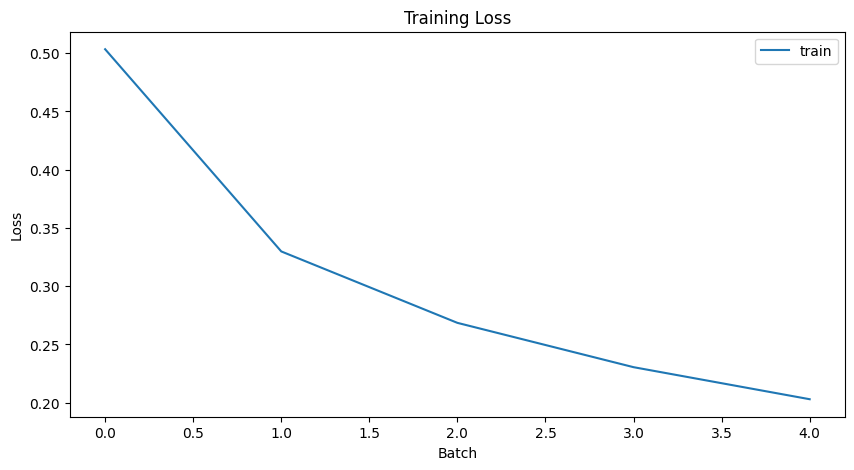

tensor([0.9385, 0.9391, 0.8868, 0.9078, 0.9272, 0.5870, 0.7215, 0.4229, 0.7970,
        0.2000, 0.5635, 0.4214, 0.6667,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan, 0.9412])

In [13]:
# Call main with train_model = False if you want to test a saved model
# The training time will take a few minutes using Colab
main(train_model = True)

In [ ]:
# Use this cell if you only want to test your trained model
# This might be useful for debugging purposes
#main(train_model = False)

## Evaluation

### Q4
a. (5pt) Looking at the F-scores over all classes, what can you observe in term of performance on the test set? Can you suggest ideas to improve the training? You can also reference the [original paper](https://www.clips.uantwerpen.be/conll2000/pdf/12732tjo.pdf) for a description of the number of each chunk in the dataset.


From the paper, we see that most of the chunks are identified as noun (51%), and the second and third chunks represent 40% of the dataset. Given the fact that there is 11 type of chunks and that 3 types compose 90% of the dataset, we could find it normal that the F-score of most of the chunks classes are very poor. 

We will have to increase the number of training example per chunks in order to increase the performance. 

b. (5pt) In this notebook, the hyper-parameters were given. How should we modify the training procedure if we were to search for the best hyper-parameter combination. Could a regularization method be useuful? If so, name one that could prove to be helpful.

If we were to tune the value of the hyperparameter in order to find the best performance. We would have to divide our dataset into 3 partitions (train, valid, test) and iterate over the validation set over a grid of hyperparameters. We would need to record the performance for each combination of hyperparameters and let the model choose the set of hyperparameters that yields the best performance.

A regularization method would be to play with the value of the hyperparameter : weight decay. This parameter takes effect when assigning a value greater than 0, which is the L2 regularization.

We can modify the training procedure this way in the main function: 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

Regularization can help to reduce overfitting and converges to lower value in the cost function. In our case, L2 regularization will shrink the parameter estimates of the non-important features and lower the complexity of the model, making the model less likely to overfit.  

